<a href="https://colab.research.google.com/github/ray-dion/Latihan-Clustering/blob/main/Latihan_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [ ]:
# Install

!pip install -q geopandas
!pip install -q geopy

In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from geopy.geocoders import Nominatim
from google.colab import auth
from google.cloud import bigquery
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Connect

In [ ]:
auth.authenticate_user()
print('Authenticated')

project_id_akun = "project-hacktiv8-449409" #GUNAKAN GCP PROJECT-ID KALIAN MASING-MASING
client = bigquery.Client(project=project_id_akun)

Authenticated


# Data Load

In [ ]:
df = client.query('''
SELECT *
FROM `bigquery-public-data.thelook_ecommerce.users`
where country = 'United States' and state != 'Hawaii'
''').to_dataframe()

df.head()

,id,first_name,last_name,email,age,gender,state,street_address,postal_code,city,country,latitude,longitude,traffic_source,created_at,user_geom
0,26629,Carly,Cochran,carlycochran@example.net,65,F,Alabama,9675 Sara Shoals Apt. 882,36608,Mobile,United States,30.680531,-88.294751,Search,2023-08-10 09:57:00+00:00,POINT(-88.29475118 30.68053087)
1,54326,Marisa,Bryant,marisabryant@example.com,52,F,Alabama,51146 Thomas Stravenue Apt. 121,36608,Mobile,United States,30.680531,-88.294751,Organic,2020-07-06 17:27:00+00:00,POINT(-88.29475118 30.68053087)
2,26909,Randall,Nguyen,randallnguyen@example.org,41,M,Alabama,1505 Howard Stream,36608,Mobile,United States,30.680531,-88.294751,Search,2024-04-27 04:22:00+00:00,POINT(-88.29475118 30.68053087)
3,15702,Ryan,Johnson,ryanjohnson@example.org,68,M,Alabama,9511 Laura Gateway Suite 484,36695,Mobile,United States,30.628959,-88.282395,Search,2023-06-25 14:49:00+00:00,POINT(-88.28239545 30.62895862)
4,49833,Daniel,Morgan,danielmorgan@example.org,47,M,Alabama,9651 Mathews Cliffs Apt. 461,36695,Mobile,United States,30.628959,-88.282395,Search,2019-06-30 00:45:00+00:00,POINT(-88.28239545 30.62895862)


In [ ]:
# define map for visualization

map = gpd.read_file("https://raw.githubusercontent.com/wri/wri-bounds/master/dist/all_countries.geojson")

map = map[map['name']=='United States of America']['geometry']

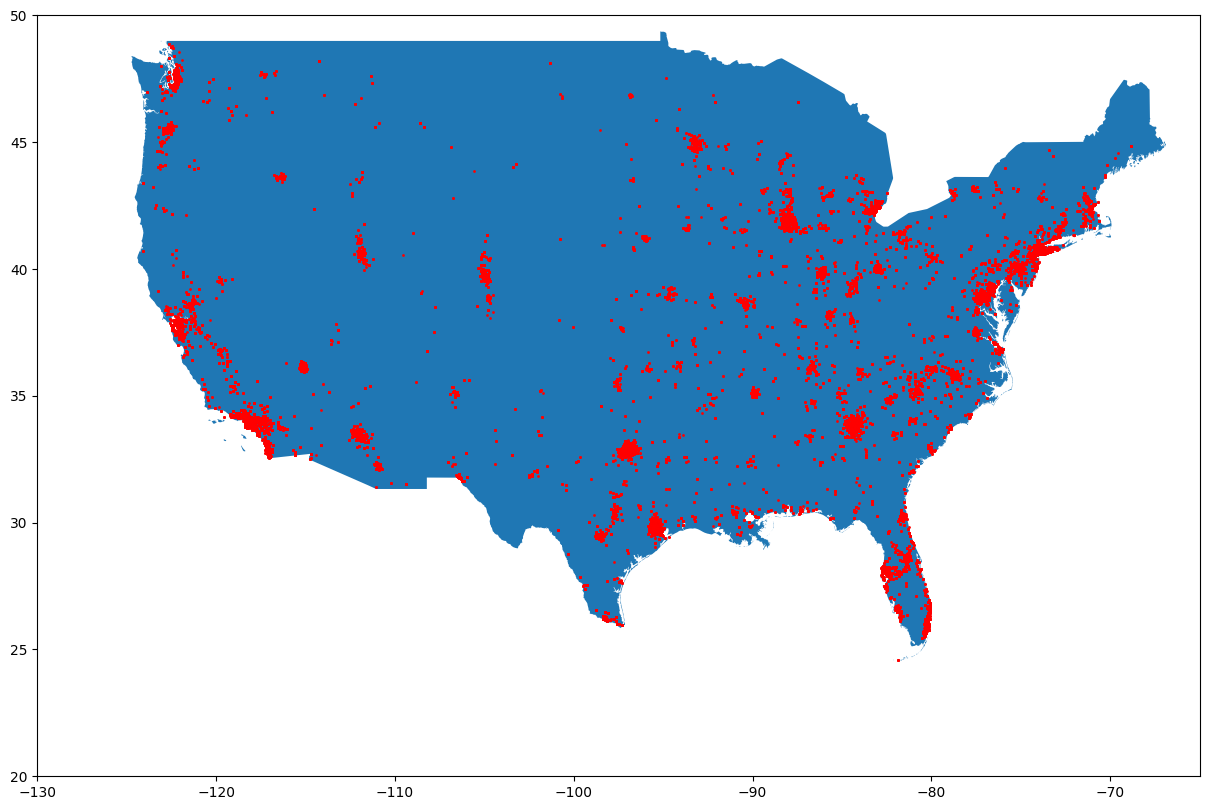

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
map.plot(ax=ax)

ax.scatter(df['longitude'], df['latitude'], color='red', s=1)

ax.set_xlim(-130, -65)
ax.set_ylim(20, 50)

plt.show()

In [ ]:
scaler = StandardScaler()

x = scaler.fit_transform(df[['longitude', 'latitude']])